In [1]:
! pip install -U numpy
! pip install missingno

Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.19.5)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear, avg, monotonically_increasing_id
from pyspark.sql.types import *
import requests
requests.packages.urllib3.disable_warnings()
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, date_format
from pyspark.sql import SparkSession, SQLContext, GroupedData, HiveContext
from pyspark.sql.functions import *
from pyspark.sql.functions import date_add as d_add
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql import Row
import datetime, time
import seaborn as sns
import numpy as np
import tools as tools
import tables_func as ct
import matplotlib.pyplot as plt
%matplotlib inline

## Scope of the Project:
- In this project I will gather the data from two sources. I will load this data into staging dataframes. I will clean the raw data, write it to parquet files and perform an ETL process using a Spark cluster. Then I will write the data into Fact & Dimension tables to form a star schema. The star schema can then be used by the relevant parties to perform data analytics, correlation and ad-hoc reporting in an effective and efficient manner.
### Data Descriptions:

- Edu_ministry is Sample data of saudi scholarships students records from the Ministry of Education. This data source will serve as the Fact table in the schema. This data comes from https://od.data.gov.sa/Data/ar/group/education_and_training?page=2 :'البوابة الوطنية للبيانات المفتوحة'.


- Countries of the World :This dataset contains Country names linked to region, population, area size, GDP, mortality and more.

  This data comes from Kaggle: https://www.kaggle.com/datasets/fernandol/countries-of-the-world

In [3]:
    spark = SparkSession\
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()

In [4]:
#import shutil

#shutil.rmtree('../Project/parquet_tables')

 ### Spark configuration parameters
 - ('spark.executor.id', 'driver'),
 - ('spark.app.name', 'pyspark-shell'),
 - ('spark.driver.port', '33753'),
 - ('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:2.7.0'),
 - ('spark.rdd.compress', 'True'),
 - ('spark.serializer.objectStreamReset', '100'),
 - ('spark.master', 'local[*]'),
 - ('spark.driver.host', 'ad2cb8c219e1'),
 - ('spark.submit.deployMode', 'client'),
 - ('spark.jars',

In [5]:
fname = '../Project/Sources/Edu_minisrty.csv'
edu_df = pd.read_csv(fname)

In [6]:
edu_df.head()

,السنة الدراسية,القطاع الدولي,فئة الإبتعاث,المرحلة الدراسية,المجال الواسع,الجنس,العدد
0,2015.0,استراليا,طالب مبتعث,أخرى,الأعمال، الإدارة والقانون,أنثى,11.0
1,2015.0,استراليا,طالب مبتعث,أخرى,الأعمال، الإدارة والقانون,ذكر,6.0
2,2015.0,استراليا,طالب مبتعث,أخرى,التعليم,أنثى,4.0
3,2015.0,استراليا,طالب مبتعث,أخرى,الصحة والرفاه,أنثى,3.0
4,2015.0,استراليا,طالب مبتعث,أخرى,العلوم الطبيعية، والرياضايات والإحصاء,ذكر,1.0


In [7]:
fname = '../Project/Sources/countries of the world.csv'
country_df = pd.read_csv(fname)

In [8]:
country_df.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Exploration and Assessing the Data
#### Data Cleaning:
- Drop columns containing over 90% missing values
- Drop duplicate values

In [9]:
# checking missing values 
edu_df.isnull().sum()

السنة الدراسية       0
القطاع الدولي        0
فئة الإبتعاث         0
المرحلة الدراسية     0
المجال الواسع        0
الجنس                0
العدد                0
dtype: int64

In [10]:
# Drop columns with over 90% missing values
clean_edu = tools.eliminate_missing_data(edu_df)

Dropping missing data...
Cleaning complete!


In [11]:
clean_edu = tools.drop_duplicate_rows(clean_edu)

Dropping duplicate rows...
0 rows dropped.


In [12]:
# Drop columns with over 90% missing values
clean_country = tools.eliminate_missing_data(country_df)

Dropping missing data...
Cleaning complete!


In [13]:
clean_country = tools.drop_duplicate_rows(clean_country)

Dropping duplicate rows...
0 rows dropped.


#### Now I'll translate the dataset to english language

In [14]:
clean_edu = ct.translate_en(clean_edu)
clean_edu.head()

,Academic_year,Country,Scholarship_type,Educational_level,Specialization,Sex,Count
0,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",2,11.0
1,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",1,6.0
2,2015.0,Australia,Scholarship student,Other,Education,2,4.0
3,2015.0,Australia,Scholarship student,Other,Health and well-being,2,3.0
4,2015.0,Australia,Scholarship student,Other,"Natural sciences, mathematics and statistics",1,1.0


In [15]:
clean_edu['Country'].count()

3148

Males represent No.1 and females No.2

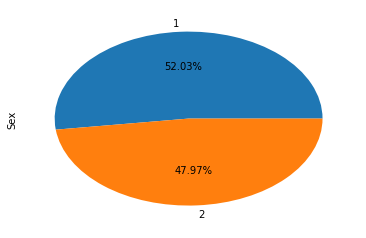

In [16]:
clean_edu['Sex'].value_counts().plot(kind='pie',autopct='%.2f%%')

Text(0.5,1,'Scholarship Types')

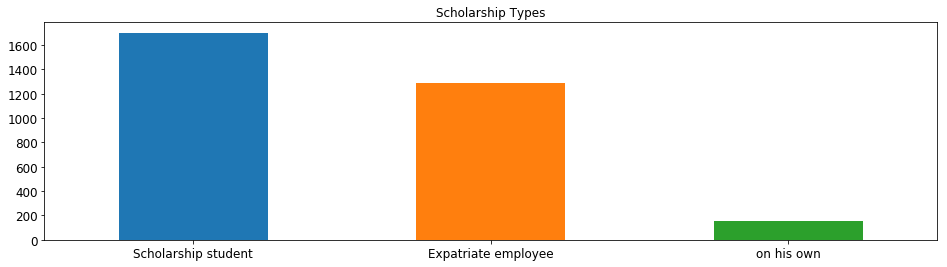

In [17]:
fig, ax = plt.subplots(figsize=(16,4))
clean_edu['Scholarship_type'].value_counts().plot(kind='bar', fontsize =12, rot = 0)
plt.title('Scholarship Types')

Text(0.5,1,'Countries')

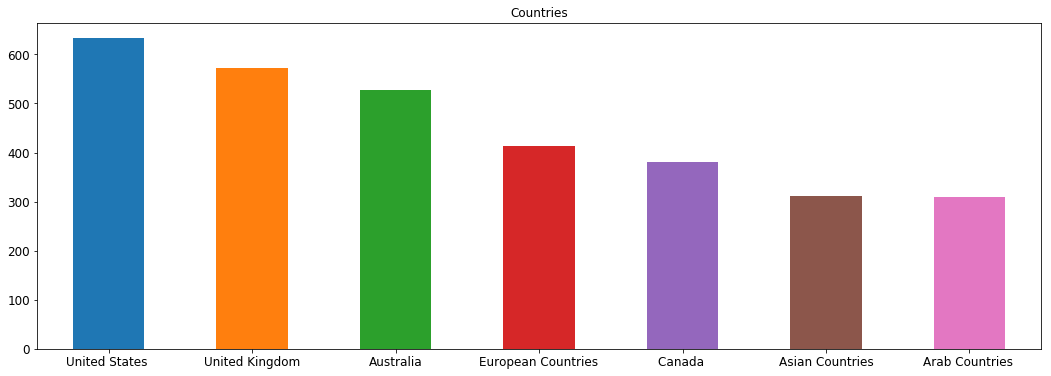

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
clean_edu['Country'].value_counts().plot(kind='bar', fontsize =12, rot = 0)
plt.title('Countries')

Text(0.5,1,'Year')

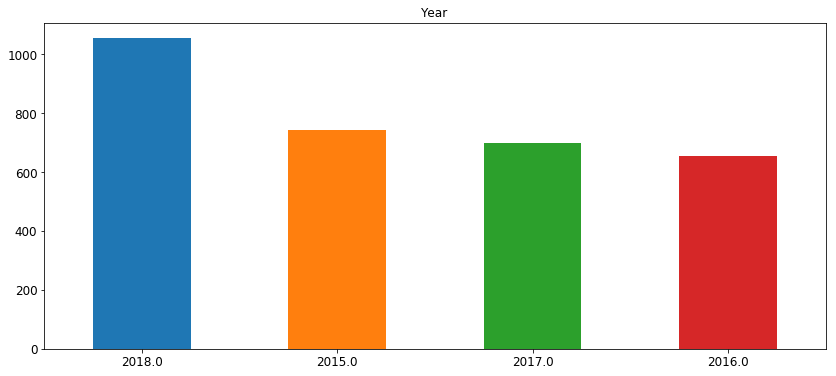

In [19]:
fig, ax = plt.subplots(figsize=(14,6))
clean_edu['Academic_year'].value_counts().plot(kind='bar', fontsize =12, rot = 0)
plt.title('Year')

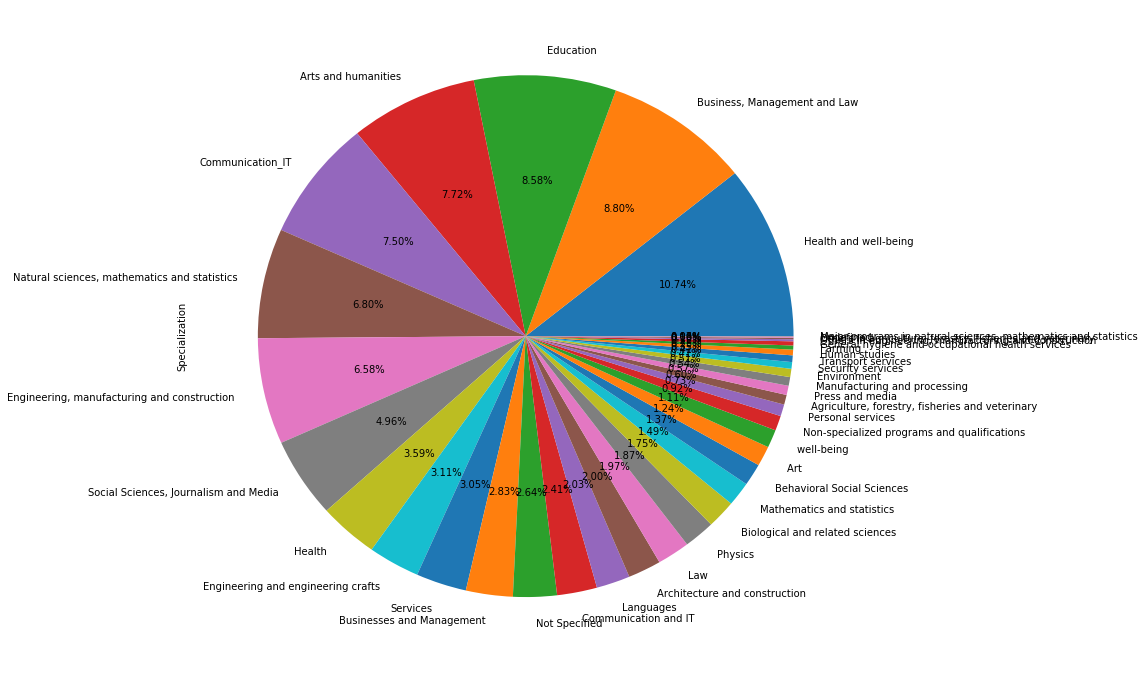

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
clean_edu['Specialization'].value_counts().plot(kind='pie',autopct='%.2f%%')

## Defining the Data Model
#### 3.1 Conceptual Data Model
In accordance with Kimball Dimensional Modelling Techniques, laid out in this document (http://www.kimballgroup.com/wp-content/uploads/2013/08/2013.09-Kimball-Dimensional-Modeling-Techniques11.pdf), the following modelling steps have been taken:

- Select the Business Process:
 - The Scholarships department follows their business process of recording scholarships students. This process generates events which are captured and translated to facts in a fact table
- Declare the Grain:
 - The grain identifies exactly what is represented in a single fact table row.
 - In this project, the grain is declared as a single occurrence of a batch of scholarships students out of the KSA.
- Identify the Dimensions:
 - Dimension tables provide context around an event or business process.
 - The dimensions identified in this project are:
   - dim_country
   - dim_specialization
- Identify the Facts:
 - Fact tables focus on the occurrences of a singular business process, and have a one-to-one relationship with the events described in the grain.
 - The fact table identified in this project is:
   - fact_scholarships
   
For this application, I have developed a set of Fact and Dimension tables in a Relational Database Management System to form a Star Schema. This Star Schema can be used by Data Analysts and other relevant business professionals to gain deeper insight into various scholarships figures, trends and statistics recorded historically.

#### 3.2 Mapping Out Data Pipelines
##### List the steps necessary to pipeline the data into the chosen data model:
- 1 Load the data into staging tables
- 2 Create Dimension tables
- 3 Create Fact table
- 4 Write data into parquet files
- 5 Perform data quality checks


## Running Pipelines to Model the Data
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [21]:
output_path = "parquet_tables/"

In [22]:
clean_edu.head()

,Academic_year,Country,Scholarship_type,Educational_level,Specialization,Sex,Count
0,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",2,11.0
1,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",1,6.0
2,2015.0,Australia,Scholarship student,Other,Education,2,4.0
3,2015.0,Australia,Scholarship student,Other,Health and well-being,2,3.0
4,2015.0,Australia,Scholarship student,Other,"Natural sciences, mathematics and statistics",1,1.0


In [23]:
# creating schema
scholarships_schema = StructType([StructField("Academic_year", StringType(), True)\
                          ,StructField("Country", StringType(), True)\
                          ,StructField("Scholarship_type", StringType(), True)\
                          ,StructField("Educational_level", StringType(), True)\
                          ,StructField("Specialization", StringType(), True)\
                          ,StructField("Sex", StringType(), True)\
                          ,StructField("Count", FloatType(), True)])

scholarships_spark = spark.createDataFrame(clean_edu, schema=scholarships_schema)

scholarships_spark.toPandas().head()

,Academic_year,Country,Scholarship_type,Educational_level,Specialization,Sex,Count
0,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",2,11.0
1,2015.0,Australia,Scholarship student,Other,"Business, Management and Law",1,6.0
2,2015.0,Australia,Scholarship student,Other,Education,2,4.0
3,2015.0,Australia,Scholarship student,Other,Health and well-being,2,3.0
4,2015.0,Australia,Scholarship student,Other,"Natural sciences, mathematics and statistics",1,1.0


In [24]:
clean_country.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [25]:
#"Country","Region","Population","Net migration","Coastline (coast/area ratio)","GDP ($ per capita)
country_schema = StructType([StructField("Country", StringType(), True)\
                             ,StructField("Region", StringType(), True)\
                             ,StructField("Population", IntegerType(), True)\
                             ,StructField("Area (sq. mi.)", IntegerType(), True)\
                             ,StructField("Pop. Density (per sq. mi.)", StringType(), True)\
                             ,StructField("Coastline (coast/area ratio", StringType(), True)\
                             ,StructField("Net migration)", StringType(), True)\
                             ,StructField("Infant mortality (per 1000 births)", StringType(), True)\
                             ,StructField("GDP ($ per capita", FloatType(), True)
                            ,StructField("Literacy (%)", StringType(), True)\
                            ,StructField("Phones (per 1000)", StringType(), True)\
                            ,StructField("Arable (%)", StringType(), True)\
                            ,StructField("Crops (%)", StringType(), True)\
                            ,StructField("Other (%)", StringType(), True)\
                            ,StructField("Climate", StringType(), True)\
                            ,StructField("Birthrate", StringType(), True)\
                            ,StructField("Deathrate", StringType(), True)\
                            ,StructField("Agriculture", StringType(), True)\
                            ,StructField("ndustry", StringType(), True)\
                            ,StructField("Service", StringType(), True)])

country_spark = spark.createDataFrame(clean_country, schema=country_schema)

country_spark.toPandas().head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio,Net migration),Infant mortality (per 1000 births),GDP ($ per capita,Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,ndustry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [26]:
# inserting missed rows
added_row = [['Arab Countries', 'MIDLE EAST',0,0,'','','','',0.0,'','','','','','','','','','','',]\
        ,['Asian Countries', 'ASIA',0,0,'','','','',0.0,'','','','','','','','','','','',]\
        ,['European Countries', 'EUROPE',0,0,'','','','',0.0,'','','','','','','','','','','',]]
 
# Creating the DataFrame
newRow = spark.createDataFrame(added_row,schema=None)
country_spark= country_spark.union(newRow)

#### 1. Create dim_Country table

In [27]:
ct.create_country_dim(country_spark, output_path)

Writing table countries to parquet_tables/countries
Write complete!


DataFrame[country_id: int, country_name: string, Region: string, Population: bigint, Coastline_area_ratio: string, Net_migration: string, GDP_$_per_capital: double]

In [28]:
country = spark.read.parquet("parquet_tables/countries")

country.toPandas().head()

,country_id,country_name,Region,Population,Coastline_area_ratio,Net_migration,GDP_$_per_capital
0,58,East Timor,ASIA (EX. NEAR EAST),1062777,"4,70",0,500.0
1,61,El Salvador,LATIN AMER. & CARIB,6822378,"1,46","-3,74",4800.0
2,111,Kuwait,NEAR EAST,2418393,"2,80","14,18",19000.0
3,46,"Congo, Repub. of the",SUB-SAHARAN AFRICA,3702314,"0,05","-0,17",700.0
4,187,Solomon Islands,OCEANIA,552438,"18,67",0,1700.0


#### 2. Create dim_Specialization table

In [29]:
ct.create_specialization_dim(scholarships_spark, output_path)

Writing table specializations to parquet_tables/specializations
Write complete!


DataFrame[spec_id: int, spec_desc: string]

In [33]:
specialization = spark.read.parquet("parquet_tables/specializations")

specialization.toPandas().head()

,spec_id,spec_desc
0,28,Biological and related sciences
1,9,"Major programs in natural sciences, mathematic..."
2,17,"Business, Management and Law"
3,4,"Others in engineering, manufacturing and const..."
4,1,"Engineering, manufacturing and construction"


#### 3. Create fact_Scholarships table

In [34]:
scholarships = ct.create_scholarships_fact(scholarships_spark, output_path, spark)

Writing table scholarships to parquet_tables/scholarships
Write complete!


In [35]:
scholarships = spark.read.parquet("parquet_tables/scholarships")

scholarships.toPandas().head()

,scholarships_id,spec_id,country_id,Academic_year,Educational_level,Sex,Count
0,786,17,228,2017.0,Master,2,16.0
1,1119,29,36,2017.0,Master,2,5.0
2,331,36,36,2015.0,Bachelor,1,27.0
3,532,29,229,2016.0,Ph.d,2,1.0
4,1492,31,214,2018.0,Master,1,131.0


In [36]:
scholarships.count()

1738

## Data Quality Checks

In [37]:
tables = {
    "specialization": specialization,
    "country": country,
    "scholarships": scholarships
}

for table_name, table in tables.items():
    tools.perform_quality_check(table, table_name)

Data quality check passed for specialization with record_count: 38 records.
Data quality check passed for country with record_count: 230 records.
Data quality check passed for scholarships with record_count: 1738 records.


In [38]:
countriesTable = spark.read.parquet("parquet_tables/countries")
specializationTable = spark.read.parquet("parquet_tables/specializations")
scholarshipsTable = spark.read.parquet('parquet_tables/scholarships')

In [39]:
#Females
scholarshipsTable.filter(scholarshipsTable.Sex == '2') \
                .select('scholarships_id', 'Sex') \
                .dropDuplicates() \
                .count()

828

In [40]:
# Males
scholarshipsTable.filter(scholarshipsTable.Sex == '1') \
                .select('scholarships_id', 'Sex') \
                .dropDuplicates() \
                .count()

910

In [38]:
query = scholarshipsTable.select(["*"])\
                .join(countriesTable, (countriesTable.country_id == scholarshipsTable.country_id), how='inner')\
                .join(specializationTable, (specializationTable.spec_id == scholarshipsTable.spec_id), how='inner')\
                .select(['scholarships_id' ,specializationTable.spec_desc.alias('Specialization Name'),countriesTable.country_name.alias('Country Name'),countriesTable.Population.alias('Country Population'),\
                        'Sex', 'Educational_level','Academic_year','count'])\
                .filter(countriesTable.country_name != ('Asian Countries'))\
                .filter(countriesTable.country_name != ('European Countries'))\
                .filter(countriesTable.country_name != ('Arab Countries'))
query.toPandas().head(50)

,scholarships_id,Specialization Name,Country Name,Country Population,Sex,Educational_level,Academic_year,count
0,170,"Business, Management and Law",United States,298444215,2,Other,2015.0,1.0
1,171,"Business, Management and Law",United States,298444215,1,Other,2015.0,4.0
2,172,Education,United States,298444215,2,Other,2015.0,1.0
3,173,Education,United States,298444215,1,Other,2015.0,6.0
4,174,Health and well-being,United States,298444215,1,Other,2015.0,17.0
5,175,Arts and humanities,United States,298444215,2,Other,2015.0,8.0
6,176,Arts and humanities,United States,298444215,1,Other,2015.0,2.0
7,177,"Engineering, manufacturing and construction",United States,298444215,1,Other,2015.0,1.0
8,178,Communication_IT,United States,298444215,2,Other,2015.0,1.0
9,179,Communication_IT,United States,298444215,1,Other,2015.0,2.0


## Thank you..